**Iniciando os requisitos**

In [ ]:
# Importação da biblioteca pandas
import pandas as pd

In [ ]:
# Instalação dos requisitos para o PySpark
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
!pip install -q findspark

In [ ]:
# Configurar as variáveis de ambiente
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"
# Torna o pyspark "importável"
import findspark
findspark.init()

In [ ]:
# iniciar uma sessão local
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Introducao").getOrCreate()

In [ ]:
# Verifica o SparkContext
print(spark)

# Exibe a Spark version
print(spark.version)

3.1.1


In [ ]:
# Definir quais funcões sql pyspark vamos importar
from pyspark.sql.functions import round, lit, col, collect_list, when, count, sum, max, min, avg, to_date, date_format, year, current_date, initcap, trim, isnull, mean, stddev
from pyspark.sql import functions as F
from IPython.display import display

#Carregando um arquivo CSV em um DataFrame
df = spark.read.csv("/content/drive/MyDrive/Colab Notebooks/Datasets/base_suja - Planilha1.csv", header=True, inferSchema=True)

# Mostrar as primeiras linhas do DataFrame
#df.show()

#Tratamento dos dados
#df = df.dropna()

#Verificar tipo de dados em cada coluna
df.printSchema()

#Arrumar formatação da data
df = df.fillna({
    "Data de Contratação": "20/01/2020"
})
df = df.withColumn(
    "Data Contratação",
    when(to_date(col("Data de Contratação"), "dd/MM/yyyy").isNotNull(), to_date(col("Data de Contratação"), "dd/MM/yyyy"))
    .when(to_date(col("Data de Contratação"), "dd-MM-yyyy").isNotNull(), to_date(col("Data de Contratação"), "dd-MM-yyyy"))
    .when(to_date(col("Data de Contratação"), "dd.MM.yyyy").isNotNull(), to_date(col("Data de Contratação"), "dd.MM.yyyy"))
    .when(to_date(col("Data de Contratação"), "yyyy/MM/dd").isNotNull(), to_date(col("Data de Contratação"), "yyyy/MM/dd"))
    .otherwise(None)
)

#Conversão final das datas para o formato dd/mm/yyyy

df = df.withColumn("Data_Formatada", date_format(col("Data Contratação"), "dd/MM/yyyy"))

#Extrair o ano de cada contratação
df= df.withColumn("Ano de Contratação", year(col("Data Contratação")))

#Total de anos trabalhados
#df_ano= df.withColumn("Total de Anos Trabalhados", year(current_date()) - year(col("Data Contratação")))

#Correção de finaceiro para financeiro

df = df.withColumn(
    "Área",
    when(col("Área") == "Finaceiro", "Financeiro")
    .otherwise(col("Área"))
)

df.show()


root
 |-- ID: integer (nullable = true)
 |-- Nome: string (nullable = true)
 |-- Idade: integer (nullable = true)
 |-- Área: string (nullable = true)
 |-- Salário: string (nullable = true)
 |-- Data de Contratação: string (nullable = true)
 |-- Status de Emprego: string (nullable = true)

+---+--------------+-----+----------+-------+-------------------+-----------------+----------------+--------------+------------------+
| ID|          Nome|Idade|      Área|Salário|Data de Contratação|Status de Emprego|Data Contratação|Data_Formatada|Ano de Contratação|
+---+--------------+-----+----------+-------+-------------------+-----------------+----------------+--------------+------------------+
|  1|    João Silva|   29|Financeiro|   5500|         01/02/2020|            Ativo|      2020-02-01|    01/02/2020|              2020|
|  2|   Maria Souza|   30|        RH|   4800|         15-03-2019|            ativo|      2019-03-15|    15/03/2019|              2019|
|  3|Carlos Pereira| null|Financeir

**1** - Análise de Consistência de Dados: Identificar e corrigir inconsistências nos valores de &quot;Área&quot; e
&quot;Status de Emprego&quot; (e.g., diferenças de maiúsculas/minúsculas).

In [ ]:
df = df.withColumn("Área", trim(initcap(col("Área")))) \
             .withColumn("Status de Emprego", trim(initcap(col("Status de Emprego"))))

df.show()

+---+--------------+-----+----------+-------+-------------------+-----------------+----------------+--------------+
| ID|          Nome|Idade|      Área|Salário|Data de Contratação|Status de Emprego|Data Contratação|Data_Formatada|
+---+--------------+-----+----------+-------+-------------------+-----------------+----------------+--------------+
|  1|    João Silva|   29|Financeiro|   5500|         01/02/2020|            Ativo|      2020-02-01|    01/02/2020|
|  2|   Maria Souza|   30|        Rh|   4800|         15-03-2019|            Ativo|      2019-03-15|    15/03/2019|
|  3|Carlos Pereira| null|Financeiro|   6200|         2020/04/01|            Ativo|      2020-04-01|    01/04/2020|
|  4|     Ana Clara|   27| Marketing|   4800|         12/06/2018|            Ativo|      2018-06-12|    12/06/2018|
|  5|  Fabio Santos|   31|      null|   5500|         20-11-2017|            Ativo|      2017-11-20|    20/11/2017|
|  6|   Sandra Lima|   28|        Rh|   null|         05-05-2020|       

**2** - Limpeza de Dados Faltantes: Detectar e tratar os valores ausentes na coluna &quot;Idade&quot; e &quot;Área&quot;.

In [ ]:
# Econtrar dados faltantes na coluna idade

df.select("Idade").where(col("Idade").isNull()).count() # Tem dois valores ausentes

# Preencher o dados ausentes com a média de idade dos funcionários
idade_media = df.select(mean(col("Idade"))).collect()[0][0]
print(idade_media)
df = df.na.fill({"Idade": idade_media})
df.show()

29.666666666666668
+---+--------------+-----+----------+-------+-------------------+-----------------+----------------+--------------+
| ID|          Nome|Idade|      Área|Salário|Data de Contratação|Status de Emprego|Data Contratação|Data_Formatada|
+---+--------------+-----+----------+-------+-------------------+-----------------+----------------+--------------+
|  1|    João Silva|   29|Financeiro|   5500|         01/02/2020|            Ativo|      2020-02-01|    01/02/2020|
|  2|   Maria Souza|   30|        Rh|   4800|         15-03-2019|            Ativo|      2019-03-15|    15/03/2019|
|  3|Carlos Pereira|   29|Financeiro|   6200|         2020/04/01|            Ativo|      2020-04-01|    01/04/2020|
|  4|     Ana Clara|   27| Marketing|   4800|         12/06/2018|            Ativo|      2018-06-12|    12/06/2018|
|  5|  Fabio Santos|   31|      null|   5500|         20-11-2017|            Ativo|      2017-11-20|    20/11/2017|
|  6|   Sandra Lima|   28|        Rh|   null|        

In [ ]:
# Encontrar dados faltantes na coluna área
df.select("Área").where(col("Área").isNull()).count() # Tem um dado ausente

#Preencher dado com "Não Informado":
df = df.na.fill({"Área": "Não Informado"})
df.show()

+---+--------------+-----+-------------+-------+-------------------+-----------------+----------------+--------------+
| ID|          Nome|Idade|         Área|Salário|Data de Contratação|Status de Emprego|Data Contratação|Data_Formatada|
+---+--------------+-----+-------------+-------+-------------------+-----------------+----------------+--------------+
|  1|    João Silva|   29|   Financeiro|   5500|         01/02/2020|            Ativo|      2020-02-01|    01/02/2020|
|  2|   Maria Souza|   30|           Rh|   4800|         15-03-2019|            Ativo|      2019-03-15|    15/03/2019|
|  3|Carlos Pereira|   29|   Financeiro|   6200|         2020/04/01|            Ativo|      2020-04-01|    01/04/2020|
|  4|     Ana Clara|   27|    Marketing|   4800|         12/06/2018|            Ativo|      2018-06-12|    12/06/2018|
|  5|  Fabio Santos|   31|Não Informado|   5500|         20-11-2017|            Ativo|      2017-11-20|    20/11/2017|
|  6|   Sandra Lima|   28|           Rh|   null|

**3** - Distribuição de Idade: Analisar a distribuição da idade dos funcionários por departamento.

In [ ]:
df_idade_departamento = df.groupBy("Área").agg(avg("Idade").alias("Média de idade por departamento"))
df_idade_departamento = df_idade_departamento.withColumn("Média de idade por departamento", round("Média de idade por departamento",0))
df_idade_departamento.show()

+-------------+-------------------------------+
|         Área|Média de idade por departamento|
+-------------+-------------------------------+
|           Rh|                           29.0|
|Não Informado|                           31.0|
|   Financeiro|                           29.0|
|    Marketing|                           31.0|
+-------------+-------------------------------+



In [ ]:
#Idade mínima e idade máxima por departamento
df_idade_departamento_min_max = df.groupBy("Área").agg(min("Idade").alias("Idade miníma"), max("Idade").alias("Idade máxima"))
df_idade_departamento_min_max.show()

+-------------+------------+------------+
|         Área|Idade miníma|Idade máxima|
+-------------+------------+------------+
|           Rh|          28|          30|
|Não Informado|          31|          31|
|   Financeiro|          29|          30|
|    Marketing|          27|          34|
+-------------+------------+------------+



**4** - Salário por Departamento: Calcular a média, mediana e desvio padrão dos salários por departamento.

In [ ]:
# Encontrar dados faltantes na coluna salário
df.select("Salário").where(col("Salário").isNull()).count() # Tem um dado ausente

# Preencher o dados ausentes com a média de salário
salario_media = df.select(mean(col("Salário"))).collect()[0][0]
#print(salario_media)
df = df.na.fill({"Salário": salario_media})
#df.show()

#Arrumar dados do salário: tem um valor com R$
from pyspark.sql.functions import regexp_replace, col

df= df.withColumn(
    "Salário",
    regexp_replace(col("Salário"), "R\\$\\s*", "")  # Remove "R$" e espaços
)

#df.show()

df = df.withColumn("Salário", col("Salário").cast("double"))

# Calcular a média, mediana e desvio padrão dos salários por departamento.

df_departamento_salario = df.groupBy("Área").agg(avg("Salário").alias("Média Salarial"), stddev("Salário").alias("Desvio padrão"))
df_departamento_salario.show()

# aparece null no não informado para desvio padrão, pois só há um valor

#mediana
mediana = df.approxQuantile("Salário", [0.5], 0.01)[0]

print(f"A mediana dos salários é: {mediana}")


+-------------+--------------+------------------+
|         Área|Média Salarial|     Desvio padrão|
+-------------+--------------+------------------+
|           Rh|        5000.0|346.41016151377545|
|Não Informado|        5500.0|              null|
|   Financeiro|        5700.0| 430.1162633521314|
|    Marketing|        5100.0|424.26406871192853|
+-------------+--------------+------------------+

A mediana dos salários é: 5400.0


**5** - Análise de Outliers: Identificar salários que estão fora do padrão (outliers) para cada
departamento.

In [ ]:
df_metrica= df.groupBy("Área").agg(avg("Salário").alias("Salário Médio"), stddev("Salário").alias("Desvio Padrão"))
df_metrica.show()

df_com_outliers = df.join(df_metrica, "Área").withColumn("Limite Inferior", col("Salário Médio") - 2 * col("Desvio Padrão")).withColumn("Limite Superior", col("Salário Médio") + 2 * col("Desvio Padrão"))

df_outliers = df_com_outliers.filter((col("Salário") < col("Limite Inferior")) & (col("Salário") > col("Limite Superior")))

df_outliers.show()

+-------------+-------------+------------------+
|         Área|Salário Médio|     Desvio Padrão|
+-------------+-------------+------------------+
|           Rh|       5000.0|346.41016151377545|
|Não Informado|       5500.0|              null|
|   Financeiro|       5700.0| 430.1162633521314|
|    Marketing|       5100.0|424.26406871192853|
+-------------+-------------+------------------+

+----+---+----+-----+-------+-------------------+-----------------+----------------+--------------+-------------+-------------+---------------+---------------+
|Área| ID|Nome|Idade|Salário|Data de Contratação|Status de Emprego|Data Contratação|Data_Formatada|Salário Médio|Desvio Padrão|Limite Inferior|Limite Superior|
+----+---+----+-----+-------+-------------------+-----------------+----------------+--------------+-------------+-------------+---------------+---------------+
+----+---+----+-----+-------+-------------------+-----------------+----------------+--------------+-------------+-------------+

**6** - Correlação Idade-Salário: Analisar a correlação entre idade e salário dos funcionários.

In [ ]:
df = df.withColumn("Idade", col("Idade").cast("double"))
df = df.withColumn("Salário", col("Salário").cast("double"))
coeficiente_correlacao = df.corr("Idade", "Salário")
print(coeficiente_correlacao)


0.08215352261440326


**7** - Tempo de Casa: Calcular o tempo de contratação dos funcionários e categorizá-los em grupos
(e.g., 1-3 anos, 4-6 anos, etc.).

In [ ]:
df = df.dropna()
#Extrair o ano de cada contratação
df= df.withColumn("Ano de Contratação", year(col("Data Contratação")))
#Total de anos trabalhados
df= df.withColumn("Total de Anos Trabalhados", year(current_date()) - year(col("Data Contratação")))

#df.show()

df_anos_trabalhados= df.withColumn("Categoria Anos Trabalhados",
    when((col("Total de Anos Trabalhados") >= 1) & (col("Total de Anos Trabalhados") <= 3), "1-3 anos")
    .when((col("Total de Anos Trabalhados") >= 4) & (col("Total de Anos Trabalhados") <= 6), "3-4 anos")
    .when((col("Total de Anos Trabalhados") >= 7) & (col("Total de Anos Trabalhados") <= 10), "7-10 anos")
    .otherwise("Mais de 10 anos")
)

df_anos_trabalhados.show()


+---+--------------+-----+-------------+-------+-------------------+-----------------+----------------+--------------+------------------+-------------------------+--------------------------+
| ID|          Nome|Idade|         Área|Salário|Data de Contratação|Status de Emprego|Data Contratação|Data_Formatada|Ano de Contratação|Total de Anos Trabalhados|Categoria Anos Trabalhados|
+---+--------------+-----+-------------+-------+-------------------+-----------------+----------------+--------------+------------------+-------------------------+--------------------------+
|  1|    João Silva| 29.0|   Financeiro| 5500.0|         01/02/2020|            Ativo|      2020-02-01|    01/02/2020|              2020|                        4|                  3-4 anos|
|  2|   Maria Souza| 30.0|           Rh| 4800.0|         15-03-2019|            Ativo|      2019-03-15|    15/03/2019|              2019|                        5|                  3-4 anos|
|  3|Carlos Pereira| 29.0|   Financeiro| 6200

**8** - Análise de Rotatividade: Identificar padrões entre os funcionários que estão ativos versus os que
não estão.

In [ ]:
# Média salarial entre os funcionários ativos e inativos e Média de idade dos funcinários
df_media_salarial_status = df.groupBy("Status de Emprego").agg(avg("Salário").alias("Média salarial"), avg("Idade").alias("Média de idade"))
df_media_salarial_status.show()

#Departamento com o maior número de funcionários inativos
df_inativos = df.filter(col("Status de Emprego") == "Inativo")
df_departamento_inativos = df_inativos.groupBy("Área").agg(count("ID").alias("Total"))
df_departamento_inativos.show()

#Departamento com o maior número de funcionários ativos
df_ativos = df.filter(col("Status de Emprego") == "Ativo")
df_departamento_ativos = df_ativos.groupBy("Área").agg(count("ID").alias("Total"))
df_departamento_ativos.show()

+-----------------+--------------+-----------------+
|Status de Emprego|Média salarial|   Média de idade|
+-----------------+--------------+-----------------+
|          Inativo|        5750.0|             31.5|
|            Ativo|        5300.0|29.11111111111111|
+-----------------+--------------+-----------------+

+----------+-----+
|      Área|Total|
+----------+-----+
|Financeiro|    1|
| Marketing|    1|
+----------+-----+

+-------------+-----+
|         Área|Total|
+-------------+-----+
|           Rh|    3|
|Não Informado|    1|
|   Financeiro|    4|
|    Marketing|    1|
+-------------+-----+



**9** - Análise de Desempenho por Data de Contratação: Verificar se existe uma correlação entre o ano
de contratação e o nível de salário.

In [ ]:
# Remover dado nulo
df_anos_trabalhados = df.na.drop(subset=["Data Contratação"])
#df_anos_trabalhados.show()

# Calcular a correlação
coeficiente_correlacao = df.corr("Ano de Contratação", "Salário")
print(coeficiente_correlacao)

# Coeficiente positivo indica que há correlação entre as variáveis, porém é uma correlação fraca pois está longe de 1

0.2985138993799236


**10** - Histograma de Salário: Criar um histograma de salários para visualizar a distribuição geral.

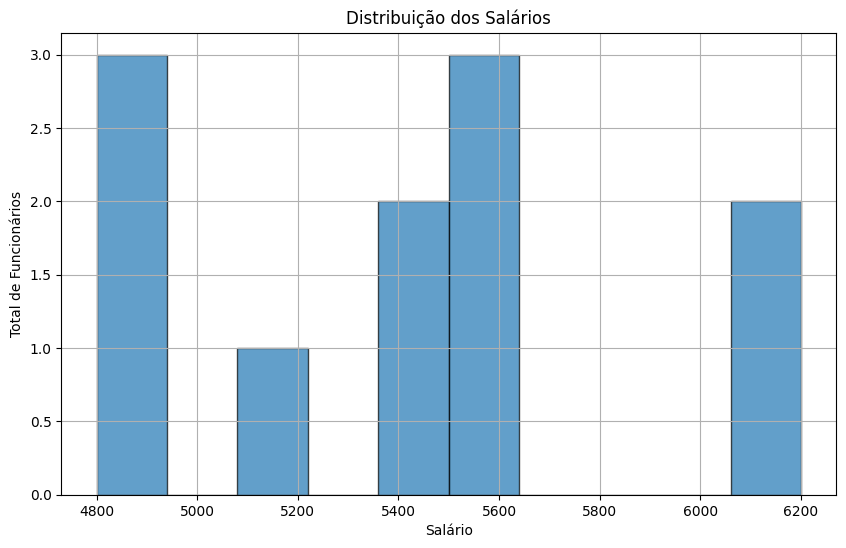

In [ ]:
import matplotlib.pyplot as plt
df = df.withColumn("Salário", col("Salário").cast("double"))

# Remover valores nulos na coluna salario
df = df.na.drop(subset=["Salário"])

# Converter o DataFrame para Pandas
df_pd = df.toPandas()

# Criar o histograma dos salários
plt.figure(figsize=(10, 6))
plt.hist(df_pd['Salário'], bins=10, edgecolor='black', alpha=0.7)
plt.xlabel('Salário')
plt.ylabel('Total de Funcionários')
plt.title('Distribuição dos Salários')
plt.grid(True)
plt.show()

**11** - Análise de Frequência: Quantificar a frequência dos nomes dos funcionários para identificar
nomes comuns.

In [ ]:
df_funcionarios_freq_nome = df.groupBy("Nome").agg(count("Nome").alias("Frequência do nome"))
df_funcionarios_freq_nome.show() #Apenas João Silva se repete

+--------------+------------------+
|          Nome|Frequência do nome|
+--------------+------------------+
|     Ana Clara|                 1|
| Paulo Ricardo|                 1|
| Fernanda Dias|                 1|
|   Sandra Lima|                 1|
|    José Alves|                 1|
| Luciana Costa|                 1|
|  Fabio Santos|                 1|
|Carlos Pereira|                 1|
|    João Silva|                 2|
|   Maria Souza|                 1|
+--------------+------------------+



**12** - Agrupamento de Departamentos: Analisar o impacto do departamento na variação salarial e na
distribuição de idade.

In [ ]:
# Agrupar por departamento e verificar a média salarial, depois agrupar por departamento e verificar a faixa etária dos funcionários
df_departamento_salario_idade = df.groupBy("Área").agg(avg("Salário").alias("Média salarial"), avg("Idade").alias("Média de idade dos funcionários"))
df_departamento_salario_idade.show()

# Definir salário máximo e mínimo por departamento e idade
df_departamento_salario_idade2 = df.groupBy("Área").agg(min("Salário").alias("Salário mínimo"), max("Salário").alias("Salário máximo"), min("Idade").alias("Menor Idade"), max("Idade").alias("Maior Idade"))
df_departamento_salario_idade2.show()

# definir o sálario médio por idade de acordo com o departamento
df_departamento_salario_idade3 = df.groupBy("Área", "Idade").agg(avg("Salário").alias("Média salarial"))
df_departamento_salario_idade3.show()

+-------------+--------------+-------------------------------+
|         Área|Média salarial|Média de idade dos funcionários|
+-------------+--------------+-------------------------------+
|           Rh|        5000.0|                           29.0|
|Não Informado|        5500.0|                           31.0|
|   Financeiro|        5700.0|                           29.2|
|    Marketing|        5100.0|                           30.5|
+-------------+--------------+-------------------------------+

+-------------+--------------+--------------+-----------+-----------+
|         Área|Salário mínimo|Salário máximo|Menor Idade|Maior Idade|
+-------------+--------------+--------------+-----------+-----------+
|           Rh|        4800.0|        5400.0|       28.0|       30.0|
|Não Informado|        5500.0|        5500.0|       31.0|       31.0|
|   Financeiro|        5200.0|        6200.0|       29.0|       30.0|
|    Marketing|        4800.0|        5400.0|       27.0|       34.0|
+----

**13** - Normalização de Dados: Normalizar o salário e idade para comparações entre diferentes
departamentos.

In [ ]:
df_metrica = df.agg(
    avg("Salário").alias("Média Salário"),
    stddev("Salário").alias("Desvio Padrão Salário"),
    avg("Idade").alias("Média Idade"),
    stddev("Idade").alias("Desvio Padrão Idade")
).collect()[0]

media_salario = df_metrica["Média Salário"]
desvio_padrao_salario = df_metrica["Desvio Padrão Salário"]
media_idade = df_metrica["Média Idade"]
desvio_padrao_idade = df_metrica["Desvio Padrão Idade"]

df_normalizado = df.withColumn("Salário Normalizado", (col("Salário") - media_salario) / desvio_padrao_salario).withColumn("Idade Normalizada", (col("Idade") - media_idade) / desvio_padrao_idade)

df_normalizado.show()

+---+--------------+-----+-------------+-------+-------------------+-----------------+----------------+--------------+------------------+-------------------------+-------------------+--------------------+
| ID|          Nome|Idade|         Área|Salário|Data de Contratação|Status de Emprego|Data Contratação|Data_Formatada|Ano de Contratação|Total de Anos Trabalhados|Salário Normalizado|   Idade Normalizada|
+---+--------------+-----+-------------+-------+-------------------+-----------------+----------------+--------------+------------------+-------------------------+-------------------+--------------------+
|  1|    João Silva| 29.0|   Financeiro| 5500.0|         01/02/2020|            Ativo|      2020-02-01|    01/02/2020|              2020|                        4|0.24770219065268412|-0.30151134457776435|
|  2|   Maria Souza| 30.0|           Rh| 4800.0|         15-03-2019|            Ativo|      2019-03-15|    15/03/2019|              2019|                        5|-1.21945693859783

**14** - Proporção de Gêneros: Analisar a proporção de gêneros entre os funcionários, caso houvesse
uma coluna de gênero.

In [ ]:
# Criar um dicionários linkando os nomes dos funcionários aos gêneros e depois criar uma coluna no df

generos = {
    'João Silva' : 'M',
    'Maria Souza' : 'F',
    'Carlos Pereira' : 'M',
    'Ana Clara' : 'F',
    'Fabio Santos' : 'M',
    'Sandra Lima' : 'F',
    'José Alves' : 'M',
    'Luciana Costa' :'F',
    'Paulo Ricardo' : 'M',
    'Fernanda Dias' : 'F',
    'João Silva' : 'M'
}

df = df.withColumn(
    "Gênero",
    when(col("Nome") == "João Silva", "M")
    .when(col("Nome") == "Maria Souza", "F")
    .when(col("Nome") == "Carlos Pereira", "M")
    .when(col("Nome") == "Ana Clara", "F")
    .when(col("Nome") == "Fabio Santos", "M")
    .when(col("Nome") == "Sandra Lima", "F")
    .when(col("Nome") == "José Alves", "M")
    .when(col("Nome") == "Luciana Costa", "F")
    .when(col("Nome") == "Paulo Ricardo", "M")
    .when(col("Nome") == "Fernanda Dias", "F")
    .when(col("Nome") == "João Silva", "M")
    .otherwise("Desconhecido")  # Caso algum nome não esteja no dicionário
)

#df.show()

# Analisar proporção
funcionarios_feminino = df.filter(col("Gênero") == "F").count()
print(f"O total de funcionários do gênero feminino é {funcionarios_feminino}")
funcionarios_masculino = df.filter(col("Gênero") == "M").count()
print(f"O total de funcionários do gênero masculino é {funcionarios_masculino}")
total_funcionarios = df.count()
print(f"O total de funcionários é {total_funcionarios}")
proporcao_feminino = funcionarios_feminino/total_funcionarios
proporcao_masculino = funcionarios_masculino/total_funcionarios

print(f"A porporção de funcionários do gênero feminino é {proporcao_feminino} e a proporção de funcionários do gênero masculino é {proporcao_masculino}")


O total de funcionários do gênero feminino é 5
O total de funcionários do gênero masculino é 6
O total de funcionários é 11
A porporção de funcionários do gênero feminino é 0.45454545454545453 e a proporção de funcionários do gênero masculino é 0.5454545454545454


**15** - Correção de Formato de Data: Uniformizar o formato das datas de contratação.

In [ ]:
#FEITO NO INÍCIO DO CÓDIGO NA PARTE DE TRATAMENTO DE DADOS

**16** - Impacto de Status no Salário: Comparar salários médios entre funcionários ativos e não ativos.

In [ ]:
df_media_salarial_status = df.groupBy("Status de Emprego").agg(avg("Salário").alias("Média salarial"))
df_media_salarial_status.show()

#Funcionário inativos tem maior média salarial do que os ativos

+-----------------+--------------+
|Status de Emprego|Média salarial|
+-----------------+--------------+
|          Inativo|        5750.0|
|            Ativo|        5300.0|
+-----------------+--------------+



**17** - Data de Contratação e Demografia: Relacionar a data de contratação com a idade dos
funcionários na época da contratação.

In [ ]:
# Descobrir a idade na contratação: diminuir a idade atual pelo total de anos trabalhados e criar nova coluna com resultado ("Idade Contratação")

df_idade_contratacao = df.withColumn("Idade Contratação", col("Idade") - col("Total de Anos Trabalhados"))
df_idade_contratacao.show()

df_relacionado_contratacao = df_idade_contratacao.groupBy("Data_Formatada").agg(avg("Idade Contratação").alias("Relação Idade"))
df_relacionado_contratacao.show()

+---+--------------+-----+-------------+-------+-------------------+-----------------+----------------+--------------+------------------+-------------------------+------+-----------------+
| ID|          Nome|Idade|         Área|Salário|Data de Contratação|Status de Emprego|Data Contratação|Data_Formatada|Ano de Contratação|Total de Anos Trabalhados|Gênero|Idade Contratação|
+---+--------------+-----+-------------+-------+-------------------+-----------------+----------------+--------------+------------------+-------------------------+------+-----------------+
|  1|    João Silva| 29.0|   Financeiro| 5500.0|         01/02/2020|            Ativo|      2020-02-01|    01/02/2020|              2020|                        4|     M|             25.0|
|  2|   Maria Souza| 30.0|           Rh| 4800.0|         15-03-2019|            Ativo|      2019-03-15|    15/03/2019|              2019|                        5|     F|             25.0|
|  3|Carlos Pereira| 29.0|   Financeiro| 6200.0|       

**18** - Distribuição de Status de Emprego: Analisar a distribuição do status de emprego (ativo vs. não
ativo).

In [ ]:
funcionarios_ativos = df.filter(col("Status de Emprego") == "Ativo").count()
print(f"O total de funcionários ativos é {funcionarios_ativos}")
funcionarios_inativos = df.filter(col("Status de Emprego") == "Inativo").count()
print(f"O total de funcionários inativos é {funcionarios_inativos}")
total_funcionarios = df.count()
print(f"O total de funcionários é {total_funcionarios}")
proporcao_ativos = funcionarios_ativos/total_funcionarios
proporcao_inativos = funcionarios_inativos/total_funcionarios

print(f"A porporção de funcionários ativos é {proporcao_ativos} e a proporção de funcionários inativos é {proporcao_inativos}")

O total de funcionários ativos é 9
O total de funcionários inativos é 2
O total de funcionários é 11
A porporção de funcionários ativos é 0.8181818181818182 e a proporção de funcionários inativos é 0.18181818181818182


**19** - Criação de Coluna de Idade de Contratação: Criar uma coluna que calcule a idade do
funcionário na época da contratação e analisar os dados.

In [ ]:
df = df.withColumn("Idade Contratação", col("Idade") - col("Total de Anos Trabalhados"))
df.show()

#Idade média dos funcionários na contratação por departamento

df_idade_analise = df.groupBy("Área").agg(avg("Idade Contratação").alias("Idade média de contratação"), min("Idade Contratação").alias("Idade Mínima de contratação"), max("Idade Contratação").alias("Idade máxima de contratação"))
df_idade_analise.show()

#Salário médio por idade de contratação

df_salario_idade = df.groupBy("Idade Contratação").agg(avg("Salário").alias("Salário médio"))
df_salario_idade.show()

+---+--------------+-----+-------------+-------+-------------------+-----------------+----------------+--------------+------------------+-------------------------+------+-----------------+
| ID|          Nome|Idade|         Área|Salário|Data de Contratação|Status de Emprego|Data Contratação|Data_Formatada|Ano de Contratação|Total de Anos Trabalhados|Gênero|Idade Contratação|
+---+--------------+-----+-------------+-------+-------------------+-----------------+----------------+--------------+------------------+-------------------------+------+-----------------+
|  1|    João Silva| 29.0|   Financeiro| 5500.0|         01/02/2020|            Ativo|      2020-02-01|    01/02/2020|              2020|                        4|     M|             25.0|
|  2|   Maria Souza| 30.0|           Rh| 4800.0|         15-03-2019|            Ativo|      2019-03-15|    15/03/2019|              2019|                        5|     F|             25.0|
|  3|Carlos Pereira| 29.0|   Financeiro| 6200.0|       

**20** - Análise de Promoções: Analisar possíveis promoções dentro da empresa ao comparar datas de
contratação e aumentos salariais, se houvesse uma coluna histórica de salários.

In [ ]:
#Criar uma coluna com percentual de aumento de salário ao longo dos anos de trabalho

aumento_salario = {
    'João Silva' : 12.5,
    'Maria Souza' : 15.5,
    'Carlos Pereira' : 13.2,
    'Ana Clara' : 18,
    'Fabio Santos' : 14.5,
    'Sandra Lima' : 8.9,
    'José Alves' : 25,
    'Luciana Costa' : 21,
    'Paulo Ricardo' : 17.5,
    'Fernanda Dias' : 13.5,
    'João Silva' : 20
}

df = df.withColumn(
    "Percentual de Aumento",
    when(col("Nome") == "João Silva", 12.5)
    .when(col("Nome") == "Maria Souza", 15.5)
    .when(col("Nome") == "Carlos Pereira", 13.2)
    .when(col("Nome") == "Ana Clara", 18)
    .when(col("Nome") == "Fabio Santos", 14.5)
    .when(col("Nome") == "Sandra Lima", 8.9)
    .when(col("Nome") == "José Alves", 25)
    .when(col("Nome") == "Luciana Costa", 21)
    .when(col("Nome") == "Paulo Ricardo", 17.5)
    .when(col("Nome") == "Fernanda Dias", 13.5)
    .when(col("Nome") == "João Silva", 20)
    .otherwise("Desconhecido")  # Caso algum nome não esteja no dicionário
)

df.show()


# analisar quais funcionários devem ser promovidos de acordo com o total de anos trablhados e aumento, por exemplo, trabalhou 5 anos e teve aumento de 15%, vai ser promovido
promocao = (col("Total de Anos Trabalhados") >= 5) & (col("Percentual de Aumento")> 13) &(col("Status de Emprego") != "Inativo")
df_funcionarios_promocao = df.filter(promocao)
df_funcionarios_promocao.show()


+---+--------------+-----+-------------+-------+-------------------+-----------------+----------------+--------------+------------------+-------------------------+------+-----------------+---------------------+
| ID|          Nome|Idade|         Área|Salário|Data de Contratação|Status de Emprego|Data Contratação|Data_Formatada|Ano de Contratação|Total de Anos Trabalhados|Gênero|Idade Contratação|Percentual de Aumento|
+---+--------------+-----+-------------+-------+-------------------+-----------------+----------------+--------------+------------------+-------------------------+------+-----------------+---------------------+
|  1|    João Silva| 29.0|   Financeiro| 5500.0|         01/02/2020|            Ativo|      2020-02-01|    01/02/2020|              2020|                        4|     M|             25.0|                 12.5|
|  2|   Maria Souza| 30.0|           Rh| 4800.0|         15-03-2019|            Ativo|      2019-03-15|    15/03/2019|              2019|                   

**21** - Análise de Desempenho Temporal: Verificar se o tempo de casa influencia o salário ou a
permanência no emprego.

In [ ]:
df_desempenho_temporal = df.groupBy("Total de Anos Trabalhados").agg(avg("Salário").alias("Salário médio"))
df_desempenho_temporal.show() #Não influencia, o funcionário com 4 anos de trabalho tem salário maior q o funcionário com 7 anos

#correlação total de anos trabalhados/salário
coeficiente_correlacao_salario = df.corr("Total de Anos Trabalhados", "Salário")
print(coeficiente_correlacao_salario) #correlação negativa, indicando que as duas variáveis são inversamente proporcionais e tem pouca correlação

# Status de emprego

df_status_anos_trabalho = df.select("Status de Emprego", "Total de Anos Trabalhados")
df_status_anos_trabalho.show()

df_desempenho_status = df.groupBy("Status de Emprego").agg(avg("Total de Anos Trabalhados").alias("Média de anos trabalhados"))
df_desempenho_status.show()
#Em geral funcionários ativos e inativos possuem média de anos trabalhados próximas


+-------------------------+-----------------+
|Total de Anos Trabalhados|    Salário médio|
+-------------------------+-----------------+
|                        6|           5100.0|
|                        5|           5000.0|
|                        4|5583.333333333333|
|                        7|           5500.0|
+-------------------------+-----------------+

-0.29851389937991696
+-----------------+-------------------------+
|Status de Emprego|Total de Anos Trabalhados|
+-----------------+-------------------------+
|            Ativo|                        4|
|            Ativo|                        5|
|            Ativo|                        4|
|            Ativo|                        6|
|            Ativo|                        7|
|            Ativo|                        4|
|          Inativo|                        6|
|            Ativo|                        5|
|          Inativo|                        4|
|            Ativo|                        4|
|           

**22** - Filtragem por Data de Contratação: Identificar funcionários contratados em períodos específicos
(e.g., antes de 2019, entre 2019-2020).

In [ ]:
#2017 - 2020: anos de contratação

df.dropna()

data_limite = "01/01/2019"
data_limite_conv = to_date(lit(data_limite), 'dd/MM/yyyy')
df = df.withColumn("Data_Formatada", to_date(col("Data_Formatada"), 'dd/MM/yyyy'))

df_funcionarios_2019 = df.filter(col('Data_Formatada') < data_limite_conv)
df_funcionarios_2019.show()
df_funcionarios_2020 = df.filter(col('Data_Formatada') >= data_limite_conv)
df_funcionarios_2020.show()

+---+------------+-----+-------------+-------+-------------------+-----------------+----------------+--------------+------------------+-------------------------+------+-----------------+---------------------+
| ID|        Nome|Idade|         Área|Salário|Data de Contratação|Status de Emprego|Data Contratação|Data_Formatada|Ano de Contratação|Total de Anos Trabalhados|Gênero|Idade Contratação|Percentual de Aumento|
+---+------------+-----+-------------+-------+-------------------+-----------------+----------------+--------------+------------------+-------------------------+------+-----------------+---------------------+
|  4|   Ana Clara| 27.0|    Marketing| 4800.0|         12/06/2018|            Ativo|      2018-06-12|    2018-06-12|              2018|                        6|     F|             21.0|                   18|
|  5|Fabio Santos| 31.0|Não Informado| 5500.0|         20-11-2017|            Ativo|      2017-11-20|    2017-11-20|              2017|                        7|   

**23** - Análise de Status de Emprego e Tempo de Casa: Verificar a relação entre tempo de casa e status de emprego (ativo vs. não ativo).

In [ ]:
df_trabalho_status = df.groupBy("Status de Emprego").agg(avg("Total de Anos Trabalhados").alias("Média de Anos Trabalhados"), min("Total de Anos Trabalhados").alias("Tempo mínimo de trabalho"), max("Total de Anos Trabalhados").alias("Máximo de anos trabalhados"))
df_trabalho_status.show()

df_trabalho_status_area = df.groupBy("Status de Emprego", "Área").agg(avg("Total de Anos Trabalhados").alias("Média de Anos Trabalhados"), min("Total de Anos Trabalhados").alias("Tempo mínimo de trabalho"), max("Total de Anos Trabalhados").alias("Máximo de anos trabalhados"))
df_trabalho_status_area.show()

+-----------------+-------------------------+------------------------+--------------------------+
|Status de Emprego|Média de Anos Trabalhados|Tempo mínimo de trabalho|Máximo de anos trabalhados|
+-----------------+-------------------------+------------------------+--------------------------+
|          Inativo|                      5.0|                       4|                         6|
|            Ativo|        4.777777777777778|                       4|                         7|
+-----------------+-------------------------+------------------------+--------------------------+

+-----------------+-------------+-------------------------+------------------------+--------------------------+
|Status de Emprego|         Área|Média de Anos Trabalhados|Tempo mínimo de trabalho|Máximo de anos trabalhados|
+-----------------+-------------+-------------------------+------------------------+--------------------------+
|            Ativo|   Financeiro|                     4.25|                

**24** - . Identificação de Funcionários Veteranos: Encontrar os funcionários com maior tempo de casa e analisar seu impacto na empresa.

In [ ]:
df_funcionarios_veteranos = df.filter(col("Total de Anos Trabalhados") >= 5).select(("Nome"), ("Área"), ("Salário"), ("Status de Emprego"))
df_funcionarios_veteranos.show()

# Verificar média do sálario desses funcionários
df_veteranos_salario = df_funcionarios_veteranos.agg(avg("Salário").alias("Salário médio"))
df_veteranos_gastototal = df_funcionarios_veteranos.agg(sum("Salário").alias("Gasto total"))
df_veteranos_salario.show()
df_veteranos_gastototal.show()

+-------------+-------------+-------+-----------------+
|         Nome|         Área|Salário|Status de Emprego|
+-------------+-------------+-------+-----------------+
|  Maria Souza|           Rh| 4800.0|            Ativo|
|    Ana Clara|    Marketing| 4800.0|            Ativo|
| Fabio Santos|Não Informado| 5500.0|            Ativo|
|   José Alves|    Marketing| 5400.0|          Inativo|
|Luciana Costa|   Financeiro| 5200.0|            Ativo|
+-------------+-------------+-------+-----------------+

+-------------+
|Salário médio|
+-------------+
|       5140.0|
+-------------+

+-----------+
|Gasto total|
+-----------+
|    25700.0|
+-----------+



**25** - Análise de Tendências de Contratação: Identificar padrões de contratação ao longo do tempo, como sazonalidade.

In [ ]:
# Extrair o mês de contratação de cada funcionário
from pyspark.sql.functions import month

df = df.withColumn("Mês de Contratação", month(col("Data_Formatada")))
df.show()

# Definir o número de contratações por determinado mês e ano
df_sazonalidade_contratacao_ano = df.groupBy("Ano de Contratação").agg(count("Nome").alias("Número de Contratações"))
df_sazonalidade_contratacao_ano.show()

df_sazonalidade_contratacao_mes = df.groupBy("Mês de Contratação").agg(count("Nome").alias("Número de Contratações"))
df_sazonalidade_contratacao_mes = df_sazonalidade_contratacao_mes.orderBy("Mês de Contratação")
df_sazonalidade_contratacao_mes.show()

+---+--------------+-----+-------------+-------+-------------------+-----------------+----------------+--------------+------------------+-------------------------+------+-----------------+---------------------+------------------+
| ID|          Nome|Idade|         Área|Salário|Data de Contratação|Status de Emprego|Data Contratação|Data_Formatada|Ano de Contratação|Total de Anos Trabalhados|Gênero|Idade Contratação|Percentual de Aumento|Mês de Contratação|
+---+--------------+-----+-------------+-------+-------------------+-----------------+----------------+--------------+------------------+-------------------------+------+-----------------+---------------------+------------------+
|  1|    João Silva| 29.0|   Financeiro| 5500.0|         01/02/2020|            Ativo|      2020-02-01|    2020-02-01|              2020|                        4|     M|             25.0|                 12.5|                 2|
|  2|   Maria Souza| 30.0|           Rh| 4800.0|         15-03-2019|            

**26** - Salário Máximo e Mínimo por Departamento: Determinar os salários mais altos e mais baixos dentro de cada departamento

In [ ]:
df_salario_area = df.groupBy("Área").agg(max("Salário").alias("Salário máximo"), min("Salário").alias("Salário Mínimo"))
df_salario_area.show()

+-------------+--------------+--------------+
|         Área|Salário máximo|Salário Mínimo|
+-------------+--------------+--------------+
|           Rh|        5400.0|        4800.0|
|Não Informado|        5500.0|        5500.0|
|   Financeiro|        6200.0|        5200.0|
|    Marketing|        5400.0|        4800.0|
+-------------+--------------+--------------+



**27** - Classificação de Funcionários por Salário: Criar rankings de funcionários por salário dentro de cada departamento.

In [ ]:
# Salário 2000 - 4000 --> Funcionário nível 1
# Salário 4001 - 6000 --> Funcionário nível 2
# Salário 6001 - 10000 --> Funcionário nível 3

df = df.withColumn(
    "Nível do Funcionário",
    when((col("Salário") >= 2000) & (col("Salário") <= 4000), "Funcionário Nível 1")
    .when((col("Salário") >= 4001) & (col("Salário") <= 6000), "Funcionário Nível 2")
    .when((col("Salário") >= 6001) & (col("Salário") <= 10000), "Funcionário Nível 3")
    .otherwise("Não classificado")
)

df.show()
df.select("Nome", "Salário", "Nível do Funcionário").show()


+---+--------------+-----+-------------+-------+-------------------+-----------------+----------------+--------------+------------------+-------------------------+------+-----------------+---------------------+------------------+--------------------+
| ID|          Nome|Idade|         Área|Salário|Data de Contratação|Status de Emprego|Data Contratação|Data_Formatada|Ano de Contratação|Total de Anos Trabalhados|Gênero|Idade Contratação|Percentual de Aumento|Mês de Contratação|Nível do Funcionário|
+---+--------------+-----+-------------+-------+-------------------+-----------------+----------------+--------------+------------------+-------------------------+------+-----------------+---------------------+------------------+--------------------+
|  1|    João Silva| 29.0|   Financeiro| 5500.0|         01/02/2020|            Ativo|      2020-02-01|    2020-02-01|              2020|                        4|     M|             25.0|                 12.5|                 2| Funcionário Nível

**28** - Projeção de Aposentadoria: Estimar o número de funcionários que podem se aposentar em breve com base na idade.

In [ ]:
#Criar uma coluna com o total de anos até a aposentadoria, considerando que seja 60 anos
from pyspark.sql.functions import expr

idade_aposentadoria = 60

df = df.withColumn(
    "Total de Anos Até Aposentadoria",
    expr(f"{idade_aposentadoria} - Idade")
)

df.show()

df_aposentadoria = df.filter(col("Total de Anos Até Aposentadoria") <= 10)
df_aposentadoria.select("Nome", "Idade", "Total de Anos Até Aposentadoria").show() #Ninguém

+---+--------------+-----+-------------+-------+-------------------+-----------------+----------------+--------------+------------------+-------------------------+------+-----------------+---------------------+------------------+--------------------+-------------------------------+
| ID|          Nome|Idade|         Área|Salário|Data de Contratação|Status de Emprego|Data Contratação|Data_Formatada|Ano de Contratação|Total de Anos Trabalhados|Gênero|Idade Contratação|Percentual de Aumento|Mês de Contratação|Nível do Funcionário|Total de Anos Até Aposentadoria|
+---+--------------+-----+-------------+-------+-------------------+-----------------+----------------+--------------+------------------+-------------------------+------+-----------------+---------------------+------------------+--------------------+-------------------------------+
|  1|    João Silva| 29.0|   Financeiro| 5500.0|         01/02/2020|            Ativo|      2020-02-01|    2020-02-01|              2020|              

**29** - Segmentação de Funcionários por Faixa Salarial: Agrupar funcionários em faixas salariais (e.g., 2000-3000, 3001-4000) e analisar a distribuição.

In [ ]:
df = df.withColumn(
    "Faixa Salarial",
    when((col("Salário") >= 2000) & (col("Salário") <= 3000), "Faixa 2000 - 3000")
    .when((col("Salário") >= 3001) & (col("Salário") <= 4000), "Faixa 3001 - 4000")
    .when((col("Salário") >= 4001) & (col("Salário") <= 5000), "Faixa 4001 - 5000")
    .when((col("Salário") >= 5001) & (col("Salário") <= 6000), "Faixa 5001 - 6000")
    .when((col("Salário") >= 6001) & (col("Salário") <= 7000), "Faixa 6001 - 7000")
    .otherwise("Não classificado")
)

df.show()

#Contar a quantidade cada funcionarios em cada faixa

df_faixa_funcionarios = df.groupBy("Faixa Salarial").agg(count("Nome").alias("Total de Funcionários"))
df_faixa_funcionarios.show()

+---+--------------+-----+-------------+-------+-------------------+-----------------+----------------+--------------+------------------+-------------------------+------+-----------------+---------------------+------------------+--------------------+-------------------------------+-----------------+
| ID|          Nome|Idade|         Área|Salário|Data de Contratação|Status de Emprego|Data Contratação|Data_Formatada|Ano de Contratação|Total de Anos Trabalhados|Gênero|Idade Contratação|Percentual de Aumento|Mês de Contratação|Nível do Funcionário|Total de Anos Até Aposentadoria|   Faixa Salarial|
+---+--------------+-----+-------------+-------+-------------------+-----------------+----------------+--------------+------------------+-------------------------+------+-----------------+---------------------+------------------+--------------------+-------------------------------+-----------------+
|  1|    João Silva| 29.0|   Financeiro| 5500.0|         01/02/2020|            Ativo|      2020-

**30** - . Análise de Equidade Salarial: Verificar se há desigualdade salarial dentro de departamentos específicos.

In [ ]:
# equidade salarial entre os departamentos de marketing e financeiro

df_financeiro_marketing = df.filter(col("Área").isin("Financeiro", "Marketing"))
df_financeiro_marketing.show()
df_equiadade_salarial = df_financeiro_marketing.groupBy("Área").agg(avg("Salário").alias("Média Salarial"), min("Salário").alias("Salário Mínimo"), max("Salário").alias("Salário Máximo"))
df_equiadade_salarial.show()

+---+--------------+-----+----------+-------+-------------------+-----------------+----------------+--------------+------------------+-------------------------+------+-----------------+---------------------+------------------+--------------------+-------------------------------+-----------------+
| ID|          Nome|Idade|      Área|Salário|Data de Contratação|Status de Emprego|Data Contratação|Data_Formatada|Ano de Contratação|Total de Anos Trabalhados|Gênero|Idade Contratação|Percentual de Aumento|Mês de Contratação|Nível do Funcionário|Total de Anos Até Aposentadoria|   Faixa Salarial|
+---+--------------+-----+----------+-------+-------------------+-----------------+----------------+--------------+------------------+-------------------------+------+-----------------+---------------------+------------------+--------------------+-------------------------------+-----------------+
|  1|    João Silva| 29.0|Financeiro| 5500.0|         01/02/2020|            Ativo|      2020-02-01|    20

**31** - Comparação de Salários por Período de Contratação: Comparar os salários de funcionários contratados em diferentes anos para identificar tendências de aumento salarial.

In [ ]:
df_comparar_salarios = df.groupBy("Ano de Contratação").agg(avg("Salário").alias("Média Salarial"), min("Salário").alias("Salário Mínimo"), max("Salário").alias("Salário Máximo"))
df_comparar_salarios.show()


+------------------+-----------------+--------------+--------------+
|Ano de Contratação|   Média Salarial|Salário Mínimo|Salário Máximo|
+------------------+-----------------+--------------+--------------+
|              2018|           5100.0|        4800.0|        5400.0|
|              2019|           5000.0|        4800.0|        5200.0|
|              2020|5583.333333333333|        4800.0|        6200.0|
|              2017|           5500.0|        5500.0|        5500.0|
+------------------+-----------------+--------------+--------------+



**32** - Criação de Coluna de Faixa Etária: Agrupar os funcionários em faixas etárias (e.g., 20-30 anos, 31-40 anos) e analisar diferenças entre elas.

In [ ]:
df = df.withColumn(
    "Faixa Etária",
    when((col("Idade") >= 20) & (col("Idade") <= 3000), "Faixa 20 - 30 anos")
    .when((col("Idade") >= 31) & (col("Idade") <= 40), "Faixa 31 - 40 anos")
    .when((col("Idade") >= 41) & (col("Idade") <= 50), "Faixa 41 - 50 anos")
    .when((col("Idade") >= 51) & (col("Idade") <= 60), "Faixa 51 - 60 anos")
    .otherwise("Não classificado")
)

df.show()

#Diferença salarial entre as faixas etárias

df_salario_faixa_etaria = df.groupBy("Faixa Etária").agg(avg("Salário").alias("Média Salarial"), min("Salário").alias("Salário Mínimo"), max("Salário").alias("Salário Máximo"))
df_salario_faixa_etaria.show()

#Diferença etária entre departamentos

df_area_faixa_etaria = df.groupBy("Área", "Faixa Etária").agg(count("Nome").alias("Total de funcionários")).show()

+---+--------------+-----+-------------+-------+-------------------+-----------------+----------------+--------------+------------------+-------------------------+------+-----------------+---------------------+------------------+--------------------+-------------------------------+-----------------+------------------+
| ID|          Nome|Idade|         Área|Salário|Data de Contratação|Status de Emprego|Data Contratação|Data_Formatada|Ano de Contratação|Total de Anos Trabalhados|Gênero|Idade Contratação|Percentual de Aumento|Mês de Contratação|Nível do Funcionário|Total de Anos Até Aposentadoria|   Faixa Salarial|      Faixa Etária|
+---+--------------+-----+-------------+-------+-------------------+-----------------+----------------+--------------+------------------+-------------------------+------+-----------------+---------------------+------------------+--------------------+-------------------------------+-----------------+------------------+
|  1|    João Silva| 29.0|   Financeiro|

**33** - Relação Entre Área e Tempo de Contratação: Identificar se alguns departamentos tendem a manter seus funcionários por mais tempo do que outros.

In [ ]:
df_area_tempo_contrato = df.groupBy("Área").agg(avg("Total de Anos Trabalhados").alias("Média de Anos Trabalhados"))
df_area_tempo_contrato.show()

+-------------+-------------------------+
|         Área|Média de Anos Trabalhados|
+-------------+-------------------------+
|           Rh|        4.333333333333333|
|Não Informado|                      7.0|
|   Financeiro|                      4.2|
|    Marketing|                      6.0|
+-------------+-------------------------+



**34** - Previsão de Turnover: Usar dados históricos para prever quais funcionários têm maior probabilidade de deixar a empresa.

In [ ]:
df_turnover = df.groupBy("Status de Emprego").agg(avg("Total de Anos Trabalhados").alias("Média de Anos Trabalhados")).show()

#Média de anos trabalhados de funcionários inativos é de 5 anos

#Determinar funcionários que tem mais de 5 anos de casa

df_funcionarios_previsao = df.filter(col("Total de Anos Trabalhados") >= 5).select("Nome", "Área", "Ano de Contratação")
df_funcionarios_previsao.show()


+-----------------+-------------------------+
|Status de Emprego|Média de Anos Trabalhados|
+-----------------+-------------------------+
|          Inativo|                      5.0|
|            Ativo|        4.777777777777778|
+-----------------+-------------------------+

+-------------+-------------+------------------+
|         Nome|         Área|Ano de Contratação|
+-------------+-------------+------------------+
|  Maria Souza|           Rh|              2019|
|    Ana Clara|    Marketing|              2018|
| Fabio Santos|Não Informado|              2017|
|   José Alves|    Marketing|              2018|
|Luciana Costa|   Financeiro|              2019|
+-------------+-------------+------------------+



**35** - Análise de Homogeneidade Salarial: Verificar a homogeneidade dos salários dentro de cada departamento.

In [ ]:
df_homogeneidade_salarial = df.groupBy("Área").agg(avg("Salário").alias("Média Salarial"), min("Salário").alias("Salário Mínimo"), max("Salário").alias("Salário Máximo"), stddev("Salário").alias("Desvio Padrão"))
df_homogeneidade_salarial.show()

+-------------+--------------+--------------+--------------+------------------+
|         Área|Média Salarial|Salário Mínimo|Salário Máximo|     Desvio Padrão|
+-------------+--------------+--------------+--------------+------------------+
|           Rh|        5000.0|        4800.0|        5400.0|346.41016151377545|
|Não Informado|        5500.0|        5500.0|        5500.0|              null|
|   Financeiro|        5700.0|        5200.0|        6200.0| 430.1162633521314|
|    Marketing|        5100.0|        4800.0|        5400.0|424.26406871192853|
+-------------+--------------+--------------+--------------+------------------+



**36** - Detecção de Funcionários Com Anomalias: Identificar funcionários com salários e idades que destoam significativamente dos outros no mesmo departamento.

In [ ]:
from pyspark.sql.functions import col, avg, stddev

df_metrica_salario= df.groupBy("Área").agg(avg("Salário").alias("Média"), stddev("Salário").alias("Desvio Padrão"))
df_metrica_salario.show()

df_com_outliers_salario = df.join(df_metrica_salario, "Área").withColumn("Limite Inferior", col("Média") - 2 * col("Desvio Padrão")).withColumn("Limite Superior", col("Média") + 2 * col("Desvio Padrão"))

df_outliers_salario = df_com_outliers_salario.filter((col("Salário") < col("Limite Inferior")) & (col("Salário") > col("Limite Superior")))

df_outliers_salario.show()

+-------------+------+------------------+
|         Área| Média|     Desvio Padrão|
+-------------+------+------------------+
|           Rh|5000.0|346.41016151377545|
|Não Informado|5500.0|              null|
|   Financeiro|5700.0| 430.1162633521314|
|    Marketing|5100.0|424.26406871192853|
+-------------+------+------------------+

+----+---+----+-----+-------+-------------------+-----------------+----------------+--------------+------------------+-------------------------+------+-----------------+---------------------+------------------+--------------------+-------------------------------+--------------+------------+-----+-------------+---------------+---------------+
|Área| ID|Nome|Idade|Salário|Data de Contratação|Status de Emprego|Data Contratação|Data_Formatada|Ano de Contratação|Total de Anos Trabalhados|Gênero|Idade Contratação|Percentual de Aumento|Mês de Contratação|Nível do Funcionário|Total de Anos Até Aposentadoria|Faixa Salarial|Faixa Etária|Média|Desvio Padrão|Limite I

In [ ]:
df_metrica_idade= df.groupBy("Área").agg(avg("Idade").alias("Média"), stddev("Idade").alias("Desvio Padrão"))
df_metrica_idade.show()

df_com_outliers_idade = df.join(df_metrica_idade, "Área").withColumn("Limite Inferior", col("Média") - 2 * col("Desvio Padrão")).withColumn("Limite Superior", col("Média") + 2 * col("Desvio Padrão"))

df_outliers_idade = df_com_outliers_idade.filter((col("Idade") < col("Limite Inferior")) & (col("Idade") > col("Limite Superior")))

df_outliers_idade.show()

+-------------+-----+------------------+
|         Área|Média|     Desvio Padrão|
+-------------+-----+------------------+
|           Rh| 29.0|               1.0|
|Não Informado| 31.0|              null|
|   Financeiro| 29.2|0.4472135954999578|
|    Marketing| 30.5| 4.949747468305833|
+-------------+-----+------------------+

+----+---+----+-----+-------+-------------------+-----------------+----------------+--------------+------------------+-------------------------+------+-----------------+---------------------+------------------+--------------------+-------------------------------+--------------+------------+-----+-------------+---------------+---------------+
|Área| ID|Nome|Idade|Salário|Data de Contratação|Status de Emprego|Data Contratação|Data_Formatada|Ano de Contratação|Total de Anos Trabalhados|Gênero|Idade Contratação|Percentual de Aumento|Mês de Contratação|Nível do Funcionário|Total de Anos Até Aposentadoria|Faixa Salarial|Faixa Etária|Média|Desvio Padrão|Limite Inferior|

**37** - Comparação de Salários por Região: Se houvesse uma coluna de localização, comparar os salários entre diferentes regiões.

In [ ]:
#Criar coluna com dados de região

regiao_funcionarios = {
    'João Silva' : 'Sudeste',
    'Maria Souza' : 'Centro-oeste',
    'Carlos Pereira' : 'Sul',
    'Ana Clara' : 'Nordeste',
    'Fabio Santos' : 'Sudeste',
    'Sandra Lima' : 'Norte',
    'José Alves' : 'Nordeste',
    'Luciana Costa' : 'Centro-oeste',
    'Paulo Ricardo' : 'Sudeste',
    'Fernanda Dias' : 'Sudeste',
    'João Silva' : 'Norte'
}

df = df.withColumn(
    "Região",
    when(col("Nome") == "João Silva", 'Sudeste')
    .when(col("Nome") == "Maria Souza", 'Centro-oeste')
    .when(col("Nome") == "Carlos Pereira", 'Sul')
    .when(col("Nome") == "Ana Clara", 'Nordeste')
    .when(col("Nome") == "Fabio Santos", 'Sudeste')
    .when(col("Nome") == "Sandra Lima", 'Norte')
    .when(col("Nome") == "José Alves", 'Nordeste')
    .when(col("Nome") == "Luciana Costa",'Centro-oeste')
    .when(col("Nome") == "Paulo Ricardo", 'Sudeste')
    .when(col("Nome") == "Fernanda Dias", 'Sudeste')
    .when(col("Nome") == "João Silva",'Norte')
    .otherwise("Desconhecido")  # Caso algum nome não esteja no dicionário
)

df.show()


+---+--------------+-----+-------------+-------+-------------------+-----------------+----------------+--------------+------------------+-------------------------+------+-----------------+---------------------+------------------+--------------------+-------------------------------+-----------------+------------------+------------+
| ID|          Nome|Idade|         Área|Salário|Data de Contratação|Status de Emprego|Data Contratação|Data_Formatada|Ano de Contratação|Total de Anos Trabalhados|Gênero|Idade Contratação|Percentual de Aumento|Mês de Contratação|Nível do Funcionário|Total de Anos Até Aposentadoria|   Faixa Salarial|      Faixa Etária|      Região|
+---+--------------+-----+-------------+-------+-------------------+-----------------+----------------+--------------+------------------+-------------------------+------+-----------------+---------------------+------------------+--------------------+-------------------------------+-----------------+------------------+------------+
|

In [ ]:
df_salario_regiao = df.groupBy("Região").agg(avg("Salário").alias("Média Salarial"), min("Salário").alias("Salário Mínimo"), max("Salário").alias("Salário Máximo")).show()

+------------+--------------+--------------+--------------+
|      Região|Média Salarial|Salário Mínimo|Salário Máximo|
+------------+--------------+--------------+--------------+
|    Nordeste|        5100.0|        4800.0|        5400.0|
|         Sul|        6200.0|        6200.0|        6200.0|
|     Sudeste|        5480.0|        4800.0|        6100.0|
|Centro-oeste|        5000.0|        4800.0|        5200.0|
|       Norte|        5400.0|        5400.0|        5400.0|
+------------+--------------+--------------+--------------+



**38** - Criação de Métricas Personalizadas: Desenvolver novas métricas como "salário ajustado pela idade" ou "tempo de casa ajustado pela idade".

In [ ]:
df_metricas_personalizadas = df.withColumn(
    "Salário Ajustado pela Idade",
    col("Salário") / col("Idade")
).withColumn(
    "Tempo de Casa Ajustado Pela Idade",
    col("Total de Anos Trabalhados") / col("Idade")
).show()


+---+--------------+-----+-------------+-------+-------------------+-----------------+----------------+--------------+------------------+-------------------------+------+-----------------+---------------------+------------------+--------------------+-------------------------------+-----------------+------------------+------------+---------------------------+---------------------------------+
| ID|          Nome|Idade|         Área|Salário|Data de Contratação|Status de Emprego|Data Contratação|Data_Formatada|Ano de Contratação|Total de Anos Trabalhados|Gênero|Idade Contratação|Percentual de Aumento|Mês de Contratação|Nível do Funcionário|Total de Anos Até Aposentadoria|   Faixa Salarial|      Faixa Etária|      Região|Salário Ajustado pela Idade|Tempo de Casa Ajustado Pela Idade|
+---+--------------+-----+-------------+-------+-------------------+-----------------+----------------+--------------+------------------+-------------------------+------+-----------------+---------------------+

In [ ]:
# Situação hipotética: aumento de salário com base na idade e tempo de casa do funcionário
#criar  uma coluna que receba o salário ajustado, e colunas que contenham o percentual de aumento por idade e anos de trabalhao, e uma q some os dois percentuais
df_personalizado= df.withColumn(
    "Aumento Conforme Idade",
    col("Idade") * 0.005 * col("Salário")
).withColumn(
    "Aumento Conforme Total de Anos Trabalhados",
    col("Total de Anos Trabalhados") * 0.01 * col("Salário")
).withColumn(
    "Total de Aumentos",
    col("Aumento Conforme Idade") + col("Aumento conforme Total de Anos Trabalhados")
).withColumn(
    "Salário Ajustado",
    col("Salário") + col("Total de Aumentos")
).show()

+---+--------------+-----+-------------+-------+-------------------+-----------------+----------------+--------------+------------------+-------------------------+------+-----------------+---------------------+------------------+--------------------+-------------------------------+-----------------+------------------+------------+----------------------+------------------------------------------+-----------------+----------------+
| ID|          Nome|Idade|         Área|Salário|Data de Contratação|Status de Emprego|Data Contratação|Data_Formatada|Ano de Contratação|Total de Anos Trabalhados|Gênero|Idade Contratação|Percentual de Aumento|Mês de Contratação|Nível do Funcionário|Total de Anos Até Aposentadoria|   Faixa Salarial|      Faixa Etária|      Região|Aumento Conforme Idade|Aumento Conforme Total de Anos Trabalhados|Total de Aumentos|Salário Ajustado|
+---+--------------+-----+-------------+-------+-------------------+-----------------+----------------+--------------+--------------

**39** - Análise de Recrutamento Recente: Focar na análise dos funcionários contratados nos últimos 12 meses para ver tendências.

In [ ]:
from datetime import datetime

#data_atual = datetime.today().strftime('%d/%m/%Y')
#print(data_atual)

#supondo que seja 2021...
data_inicial = "26/08/2020"
data_inicial = to_date(lit(data_inicial), 'dd/MM/yyyy')
data_atual = "26/08/2021"
data_atual = to_date(lit(data_atual), 'dd/MM/yyyy')
df_ultimas_contratacoes = df.filter((col("Data_Formatada") >= data_inicial) & (col("Data_Formatada") <= data_atual) )
df_ultimas_contratacoes.show()


+---+-------------+-----+----------+-------+-------------------+-----------------+----------------+--------------+------------------+-------------------------+------+-----------------+---------------------+------------------+--------------------+-------------------------------+-----------------+------------------+-------+
| ID|         Nome|Idade|      Área|Salário|Data de Contratação|Status de Emprego|Data Contratação|Data_Formatada|Ano de Contratação|Total de Anos Trabalhados|Gênero|Idade Contratação|Percentual de Aumento|Mês de Contratação|Nível do Funcionário|Total de Anos Até Aposentadoria|   Faixa Salarial|      Faixa Etária| Região|
+---+-------------+-----+----------+-------+-------------------+-----------------+----------------+--------------+------------------+-------------------------+------+-----------------+---------------------+------------------+--------------------+-------------------------------+-----------------+------------------+-------+
|  9|Paulo Ricardo| 29.0|Fin

**40** - Distribuição de Funcionários por Departamento: Quantificar o número de funcionários por departamento e comparar com a média salarial.

In [ ]:
df_area_funcionarios = df.groupBy("Área").agg(count("ID").alias("Total de Funcionários"), avg("Salário").alias("Média Salarial")).show()

+-------------+---------------------+--------------+
|         Área|Total de Funcionários|Média Salarial|
+-------------+---------------------+--------------+
|           Rh|                    3|        5000.0|
|Não Informado|                    1|        5500.0|
|   Financeiro|                    5|        5700.0|
|    Marketing|                    2|        5100.0|
+-------------+---------------------+--------------+



**41** - Análise de Rotatividade por Departamento: Verificar se há departamentos com alta rotatividade de funcionários.

In [ ]:
df_rotatividade = df.groupBy("Área").agg(count(when(col("Status de Emprego") == "Inativo", True)).alias("Total de Funcionários Inativos"), count("ID").alias("Total de Funcionários"))
df_rotatividade = df_rotatividade.withColumn("Rotatividade", col("Total de Funcionários Inativos") / col("Total de Funcionários")).show()

+-------------+------------------------------+---------------------+------------+
|         Área|Total de Funcionários Inativos|Total de Funcionários|Rotatividade|
+-------------+------------------------------+---------------------+------------+
|           Rh|                             0|                    3|         0.0|
|Não Informado|                             0|                    1|         0.0|
|   Financeiro|                             1|                    5|         0.2|
|    Marketing|                             1|                    2|         0.5|
+-------------+------------------------------+---------------------+------------+



**42** - Comparação de Salários por Gênero: Se houvesse uma coluna de gênero, comparar os salários médios entre homens e mulheres.

In [ ]:
#df.show()

df_salario_genero = df.groupBy("Gênero").agg(avg("Salário").alias("Média Salarial"), min("Salário").alias("Salário Mínimo"), max("Salário").alias("Salário Máximo")).show()


+------+--------------+--------------+--------------+
|Gênero|Média Salarial|Salário Mínimo|Salário Máximo|
+------+--------------+--------------+--------------+
|     F|        5000.0|        4800.0|        5400.0|
|     M|        5700.0|        5400.0|        6200.0|
+------+--------------+--------------+--------------+



**43** - Correlação Entre Status de Emprego e Desempenho Salarial: Avaliar se há diferença significativa de salários entre diferentes status de emprego.

In [ ]:
df_desempenho_salarial = df.groupBy("Status de Emprego").agg(avg("Salário").alias("Média Salarial")).show()


+-----------------+--------------+
|Status de Emprego|Média Salarial|
+-----------------+--------------+
|          Inativo|        5750.0|
|            Ativo|        5300.0|
+-----------------+--------------+



**44** - Análise de Impacto de Promoções: Se houvesse dados de promoções, analisar o impacto das promoções no salário ao longo do tempo.

In [ ]:
#Criar colunas com dados de promoções e uma com um salário inicial, outra coluna com total de promoções

promocao = {
    'João Silva' : ['Sim', 2800,3],
    'Maria Souza' : ['Sim', 1200, 2],
    'Carlos Pereira' : ['Sim', 2000, 3],
    'Ana Clara' : ['Sim', 1800, 4],
    'Fabio Santos' : ['Sim', 3200, 2],
    'Sandra Lima' : ['Não', 5400, 0],
    'José Alves' : ['Não', 5400, 0],
    'Luciana Costa' : ['Sim', 2500, 2],
    'Paulo Ricardo' : ['Sim', 3500, 1],
    'Fernanda Dias' : ['Não', 4800, 0],
    'João Silva' : ['Sim', 2200, 3]
}

colunas = ["Promoção", "Salário Inicial", "Total de Promoções"]

df = df.withColumn(
    "Promoção",
    when(col("Nome") == "João Silva", 'Sim')
    .when(col("Nome") == "Maria Souza", 'Sim')
    .when(col("Nome") == "Carlos Pereira", 'Sim')
    .when(col("Nome") == "Ana Clara", 'Sim')
    .when(col("Nome") == "Fabio Santos", 'Sim')
    .when(col("Nome") == "Sandra Lima", 'Não')
    .when(col("Nome") == "José Alves", 'Não')
    .when(col("Nome") == "Luciana Costa",'Sim')
    .when(col("Nome") == "Paulo Ricardo", 'Sim')
    .when(col("Nome") == "Fernanda Dias", 'Não')
    .when(col("Nome") == "João Silva",'Sim')
    .otherwise("Desconhecido")   # Caso algum nome não esteja no dicionário
)

df = df.withColumn(
    "Salário Inicial",
    when(col("Nome") == "João Silva", 2800)
    .when(col("Nome") == "Maria Souza", 1200)
    .when(col("Nome") == "Carlos Pereira", 2000)
    .when(col("Nome") == "Ana Clara", 1800)
    .when(col("Nome") == "Fabio Santos", 3200)
    .when(col("Nome") == "Sandra Lima", 5400)
    .when(col("Nome") == "José Alves", 5400)
    .when(col("Nome") == "Luciana Costa",2500)
    .when(col("Nome") == "Paulo Ricardo", 3500)
    .when(col("Nome") == "Fernanda Dias", 4800)
    .when(col("Nome") == "João Silva",2200)
    .otherwise("Desconhecido")
)

df = df.withColumn(
    "Total de Promoções",
    when(col("Nome") == "João Silva", 3)
    .when(col("Nome") == "Maria Souza", 2)
    .when(col("Nome") == "Carlos Pereira", 3)
    .when(col("Nome") == "Ana Clara", 4)
    .when(col("Nome") == "Fabio Santos", 2)
    .when(col("Nome") == "Sandra Lima", 0)
    .when(col("Nome") == "José Alves", 0)
    .when(col("Nome") == "Luciana Costa",2)
    .when(col("Nome") == "Paulo Ricardo", 1)
    .when(col("Nome") == "Fernanda Dias", 0)
    .when(col("Nome") == "João Silva",3)
    .otherwise("Desconhecido")
)

df.show()

df_impacto_promocoes = df.groupBy("Total de Anos Trabalhados", "Área").agg(count("Total de Promoções").alias("Número de promoções"), avg("Salário").alias("Média Salarial Atual"), avg("Salário Inicial").alias("Média Salarial Inicial"))
df_impacto_promocoes.orderBy("Total de Anos Trabalhados").show()


+---+--------------+-----+-------------+-------+-------------------+-----------------+----------------+--------------+------------------+-------------------------+------+-----------------+---------------------+------------------+--------------------+-------------------------------+-----------------+------------------+------------+--------+---------------+------------------+
| ID|          Nome|Idade|         Área|Salário|Data de Contratação|Status de Emprego|Data Contratação|Data_Formatada|Ano de Contratação|Total de Anos Trabalhados|Gênero|Idade Contratação|Percentual de Aumento|Mês de Contratação|Nível do Funcionário|Total de Anos Até Aposentadoria|   Faixa Salarial|      Faixa Etária|      Região|Promoção|Salário Inicial|Total de Promoções|
+---+--------------+-----+-------------+-------+-------------------+-----------------+----------------+--------------+------------------+-------------------------+------+-----------------+---------------------+------------------+-----------------

**45** - Projeção de Custos Salariais: Calcular o custo projetado para a empresa em termos de salários nos próximos anos.

In [ ]:
#criar uma coluna com o percentual de aumento anual para cada funcionários

percentual_aumento = {
    'João Silva' : 0.05,
    'Maria Souza' : 0.03,
    'Carlos Pereira' : 0.05,
    'Ana Clara' : 0.02,
    'Fabio Santos' : 0.06,
    'Sandra Lima' : 0.03,
    'José Alves' : 0,
    'Luciana Costa' : 0.07,
    'Paulo Ricardo' : 0,
    'Fernanda Dias' : 0,
    'João Silva' : 0.05
}

df = df.withColumn(
    "Aumento Anual",
    when(col("Nome") == "João Silva", 0.05)
    .when(col("Nome") == "Maria Souza", 0.03)
    .when(col("Nome") == "Carlos Pereira", 0.05)
    .when(col("Nome") == "Ana Clara", 0.02)
    .when(col("Nome") == "Fabio Santos", 0.06)
    .when(col("Nome") == "Sandra Lima", 0.03)
    .when(col("Nome") == "José Alves", 0.00)
    .when(col("Nome") == "Luciana Costa", 0.07)
    .when(col("Nome") == "Paulo Ricardo", 0.00)
    .when(col("Nome") == "Fernanda Dias", 0.00)
    .otherwise(None)
)

df.show()


#Avaliar o custo com salário nos próximos 2 anos, apenas para funcionários ativos
total_anos = 2
df_ativos = df.filter(col("Status de Emprego") == "Ativo")
df_ativos.show()

# Fazer uma for para calcular o salario ao longo do tempo
for ano in range(1, total_anos + 1):
    df_ativos = df_ativos.withColumn(
        f"Salário {ano} Ano",
        col("Salário") * (1 + col("Aumento Anual")) ** ano
    )
df_ativos.show()


+---+--------------+-----+-------------+-------+-------------------+-----------------+----------------+--------------+------------------+-------------------------+------+-----------------+---------------------+------------------+--------------------+-------------------------------+-----------------+------------------+------------+--------+---------------+------------------+-------------+
| ID|          Nome|Idade|         Área|Salário|Data de Contratação|Status de Emprego|Data Contratação|Data_Formatada|Ano de Contratação|Total de Anos Trabalhados|Gênero|Idade Contratação|Percentual de Aumento|Mês de Contratação|Nível do Funcionário|Total de Anos Até Aposentadoria|   Faixa Salarial|      Faixa Etária|      Região|Promoção|Salário Inicial|Total de Promoções|Aumento Anual|
+---+--------------+-----+-------------+-------+-------------------+-----------------+----------------+--------------+------------------+-------------------------+------+-----------------+---------------------+--------

**46** - Análise de Desempenho por Escolaridade: Se houvesse uma coluna de escolaridade, analisar o impacto da escolaridade no salário.

In [ ]:
escolaridade = {
    'João Silva' : 'Mestrado',
    'Maria Souza' :'Ensino Médio',
    'Carlos Pereira' : 'Mestrado',
    'Ana Clara' : 'Bacharelado',
    'Fabio Santos' : 'Bacharelado',
    'Sandra Lima' : 'Ensino Técnico',
    'José Alves' : 'Bacharelado',
    'Luciana Costa' : 'Doutorado',
    'Paulo Ricardo' : 'Mestrado',
    'Fernanda Dias' : 'Ensino Técnico',
    'João Silva' : 'Mestrado'
}

df = df.withColumn(
    "Escolaridade",
    when(col("Nome") == "João Silva", 'Mestrado')
    .when(col("Nome") == "Maria Souza", 'Ensino Médio')
    .when(col("Nome") == "Carlos Pereira", 'Mestrado')
    .when(col("Nome") == "Ana Clara", 'Bacharelado')
    .when(col("Nome") == "Fabio Santos", 'Bacharelado')
    .when(col("Nome") == "Sandra Lima", 'Ensino Técnico')
    .when(col("Nome") == "José Alves", 'Bacharelado')
    .when(col("Nome") == "Luciana Costa", 'Doutorado')
    .when(col("Nome") == "Paulo Ricardo", 'Mestrado')
    .when(col("Nome") == "Fernanda Dias", "Ensino Técnico")
    .otherwise(None)
)

df.show()

df_escolaridade_salario = df.groupBy("Escolaridade").agg(avg("Salário").alias("Média Salarial"), min("Salário").alias("Salário Mínimo"), max("Salário").alias("Salário Máximo")).show()

+---+--------------+-----+-------------+-------+-------------------+-----------------+----------------+--------------+------------------+-------------------------+------+-----------------+---------------------+------------------+--------------------+-------------------------------+-----------------+------------------+------------+--------+---------------+------------------+-------------+--------------+
| ID|          Nome|Idade|         Área|Salário|Data de Contratação|Status de Emprego|Data Contratação|Data_Formatada|Ano de Contratação|Total de Anos Trabalhados|Gênero|Idade Contratação|Percentual de Aumento|Mês de Contratação|Nível do Funcionário|Total de Anos Até Aposentadoria|   Faixa Salarial|      Faixa Etária|      Região|Promoção|Salário Inicial|Total de Promoções|Aumento Anual|  Escolaridade|
+---+--------------+-----+-------------+-------+-------------------+-----------------+----------------+--------------+------------------+-------------------------+------+-----------------+

**47** - Comparação Entre Funcionários com Benefícios: Se houvesse dados de benefícios, comparar o salário entre funcionários que recebem ou não benefícios.

In [ ]:
beneficios = {
    'João Silva' : 'Sim',
    'Maria Souza' :'Sim',
    'Carlos Pereira' : 'Não',
    'Ana Clara' : 'Sim',
    'Fabio Santos' : 'Não',
    'Sandra Lima' : 'Não',
    'José Alves' : 'Não',
    'Luciana Costa' : 'Sim',
    'Paulo Ricardo' : 'Não',
    'Fernanda Dias' : 'Sim',
    'João Silva' : 'Sim'
}

df = df.withColumn(
    "Benefícios",
    when(col("Nome") == "João Silva", 'Sim')
    .when(col("Nome") == "Maria Souza", 'Sim')
    .when(col("Nome") == "Carlos Pereira", 'Não')
    .when(col("Nome") == "Ana Clara", 'Sim')
    .when(col("Nome") == "Fabio Santos", 'Não')
    .when(col("Nome") == "Sandra Lima", 'Não')
    .when(col("Nome") == "José Alves", 'Não')
    .when(col("Nome") == "Luciana Costa", 'Sim')
    .when(col("Nome") == "Paulo Ricardo", 'Não')
    .when(col("Nome") == "Fernanda Dias", "Sim")
    .otherwise(None)
)

df.show()

df_beneficios_salario = df.groupBy("Benefícios").agg(avg("Salário").alias("Média Salarial"), min("Salário").alias("Salário Mínimo"), max("Salário").alias("Salário Máximo")).show()

+---+--------------+-----+-------------+-------+-------------------+-----------------+----------------+--------------+------------------+-------------------------+------+-----------------+---------------------+------------------+--------------------+-------------------------------+-----------------+------------------+------------+--------+---------------+------------------+-------------+--------------+----------+
| ID|          Nome|Idade|         Área|Salário|Data de Contratação|Status de Emprego|Data Contratação|Data_Formatada|Ano de Contratação|Total de Anos Trabalhados|Gênero|Idade Contratação|Percentual de Aumento|Mês de Contratação|Nível do Funcionário|Total de Anos Até Aposentadoria|   Faixa Salarial|      Faixa Etária|      Região|Promoção|Salário Inicial|Total de Promoções|Aumento Anual|  Escolaridade|Benefícios|
+---+--------------+-----+-------------+-------+-------------------+-----------------+----------------+--------------+------------------+-------------------------+---

**48** - Análise de Desempenho por Formação Acadêmica: Se houvesse uma coluna de formação, analisar como diferentes formações afetam o salário e tempo de casa.

In [ ]:
df_escolaridade_tempo = df.groupBy("Escolaridade").agg(avg("Total de Anos Trabalhados").alias("Média de Anos Trabalhados"), avg("Salário").alias("Média Salarial")).show()

+--------------+-------------------------+-----------------+
|  Escolaridade|Média de Anos Trabalhados|   Média Salarial|
+--------------+-------------------------+-----------------+
|Ensino Técnico|                      4.0|           5100.0|
|     Doutorado|                      5.0|           5200.0|
|  Ensino Médio|                      5.0|           4800.0|
|   Bacharelado|        6.333333333333333|5233.333333333333|
|      Mestrado|                      4.0|           5825.0|
+--------------+-------------------------+-----------------+



**49** - Previsão de Salários Futuros: Usar regressão linear ou outros modelos para prever o crescimento salarial futuro.

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression

dados_regressao= [
    (2021, 42800),
    (2022, 69000),
    (2023, 70000),
    (2024, 81000),
    (2025, 82000)
]

df_regressao = spark.createDataFrame(dados_regressao, ['Ano', 'Gasto Salarial Anual'])
df_regressao.show()
assembler = VectorAssembler(inputCols=["Ano"], outputCol="features")
df_features = assembler.transform(df_regressao)
lr = LinearRegression(featuresCol="features", labelCol="Gasto Salarial Anual")
modelo = lr.fit(df_features)
print("Coeficiente:", modelo.coefficients)
print("Intercepto:", modelo.intercept)
previsoes = modelo.transform(df_features)
previsoes.select("Ano", "Gasto Salarial Anual", "prediction").show()
anos_futuros = [(2026,), (2027,), (2028,)]
df_futuros = spark.createDataFrame(anos_futuros, ['Ano'])
df_futuros_features = assembler.transform(df_futuros)
previsoes_futuras = modelo.transform(df_futuros_features)
previsoes_futuras.select("Ano", "prediction").show()


+----+--------------------+
| Ano|Gasto Salarial Anual|
+----+--------------------+
|2021|               42800|
|2022|               69000|
|2023|               70000|
|2024|               81000|
|2025|               82000|
+----+--------------------+

Coeficiente: [9039.99999752855]
Intercepto: -18218959.995000258
+----+--------------------+------------------+
| Ano|Gasto Salarial Anual|        prediction|
+----+--------------------+------------------+
|2021|               42800|50880.000004939735|
|2022|               69000| 59920.00000246987|
|2023|               70000|           68960.0|
|2024|               81000|  77999.9999975264|
|2025|               82000| 87039.99999505654|
+----+--------------------+------------------+

+----+------------------+
| Ano|        prediction|
+----+------------------+
|2026| 96079.99999258295|
|2027|105119.99999011308|
|2028|114159.99998763949|
+----+------------------+



**50** - Identificação de Padrões de Promoção Interna: Analisar os padrões de promoção dentro da empresa ao longo dos anos.

In [ ]:
#Média de prOmoções por departamento, escolaridade, total de anos trabalhados

df_promocoes = df.groupBy("Área", "Escolaridade", "Total de Anos Trabalhados").agg(avg("Total de Promoções").alias("Média de Promoções")).show()

+-------------+--------------+-------------------------+------------------+
|         Área|  Escolaridade|Total de Anos Trabalhados|Média de Promoções|
+-------------+--------------+-------------------------+------------------+
|           Rh|  Ensino Médio|                        5|               2.0|
|           Rh|Ensino Técnico|                        4|               0.0|
|    Marketing|   Bacharelado|                        6|               2.0|
|   Financeiro|      Mestrado|                        4|               2.5|
|   Financeiro|     Doutorado|                        5|               2.0|
|Não Informado|   Bacharelado|                        7|               2.0|
+-------------+--------------+-------------------------+------------------+

